In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import os
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [2]:
#Initial data processing, loading series matrix and checking one sample of expression data
data = pd.read_csv('GSE243520_series_matrix.txt', sep=r'\s+', index_col=0, comment='!')
expression_data = pd.read_csv("GSM7789851_AAV_C_2017.counts.txt", sep="\t", comment="#")
print(data.head())
print(expression_data.head())

#Loading all expression file data and merging them
combined_counts= pd.DataFrame()
counts_files = [f for f in os.listdir() if f.endswith(".counts.txt")]
print("Found files:", counts_files)
for file in counts_files:
    df = pd.read_csv(file, sep="\t", comment="#")
    gsm_id = file.split("_")[0]  # Extract GSM ID (e.g., "GSM7789851")
    df = df.rename(columns={df.columns[-1]: gsm_id})
    df = df[["Geneid", gsm_id]]  # Keep only geneid and counts
    if combined_counts.empty:
        combined_counts = df
    else:
        combined_counts = combined_counts.merge(df, on="Geneid", how="outer")

print("SEPARATOR SEPARATOR SEPARATOR")
combined_counts.set_index("Geneid",inplace=True)
print(combined_counts.head())
print(combined_counts.shape)


Empty DataFrame
Columns: [GSM7789851, GSM7789852, GSM7789853, GSM7789854, GSM7789855, GSM7789856]
Index: []
                 Geneid                                 Chr  \
0  ENSMUSG00000102693.2                                chr1   
1  ENSMUSG00000064842.3                                chr1   
2  ENSMUSG00000051951.6  chr1;chr1;chr1;chr1;chr1;chr1;chr1   
3  ENSMUSG00000102851.2                                chr1   
4  ENSMUSG00000103377.2                                chr1   

                                               Start  \
0                                            3143476   
1                                            3172239   
2  3276124;3276746;3283662;3283832;3284705;349192...   
3                                            3322980   
4                                            3435954   

                                                 End         Strand  Length  \
0                                            3144545              +    1070   
1                 

In [4]:
#Extracting meta data from series matrix file 
with open("GSE243520_series_matrix.txt", "r") as file:
    lines = file.readlines()
metadata = {}
for line in lines:
    if line.startswith("!Sample_"):
        key, *values = line.strip().split("\t")
        metadata[key] = values

metadata_df = pd.DataFrame(metadata, index=[f"GSM778985{i}" for i in range(1, 7)])
print(metadata_df.loc[:, ["!Sample_title", "!Sample_characteristics_ch1"]]) #check metadata for methodology 


           !Sample_title !Sample_characteristics_ch1
GSM7789851         "C_1"      "treatment: AAV-polyA"
GSM7789852         "C_2"      "treatment: AAV-polyA"
GSM7789853         "C_3"      "treatment: AAV-polyA"
GSM7789854       "Tyr_1"       "treatment: AAV-hTyr"
GSM7789855       "Tyr_2"       "treatment: AAV-hTyr"
GSM7789856       "Tyr_3"       "treatment: AAV-hTyr"


In [5]:
#pre-processing the data, filter zeros, log2 transformation
combined_counts = combined_counts.loc[combined_counts.sum(axis=1) > 0]
combined_counts = np.log2(combined_counts + 1)
print("Missing values:", combined_counts.isnull().sum().sum())
combined_counts.fillna(0, inplace=True)

print("Processed Data:")
print(combined_counts.head())
print("Shape:", combined_counts.shape)

Missing values: 0
Processed Data:
                       GSM7789855  GSM7789851  GSM7789852  GSM7789856  \
Geneid                                                                  
ENSMUSG00000000001.5    10.499846   10.225207   10.434628   10.762382   
ENSMUSG00000000028.16    6.129283    6.087463    6.000000    5.807355   
ENSMUSG00000000031.18    6.614710    3.906891    4.523562    4.392317   
ENSMUSG00000000037.18    5.700440    6.584963    5.882643    6.977280   
ENSMUSG00000000049.12    3.169925    2.807355    3.459432    3.807355   

                       GSM7789853  GSM7789854  
Geneid                                         
ENSMUSG00000000001.5    10.481799   10.467606  
ENSMUSG00000000028.16    5.321928    5.781360  
ENSMUSG00000000031.18    3.321928    3.459432  
ENSMUSG00000000037.18    6.794416    5.832890  
ENSMUSG00000000049.12    4.857981    4.459432  
Shape: (36207, 6)


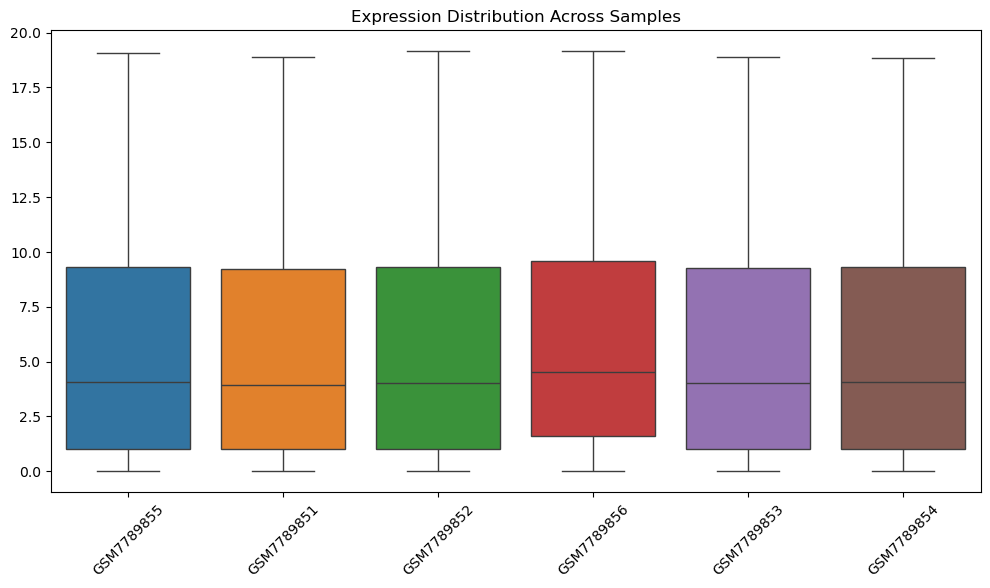

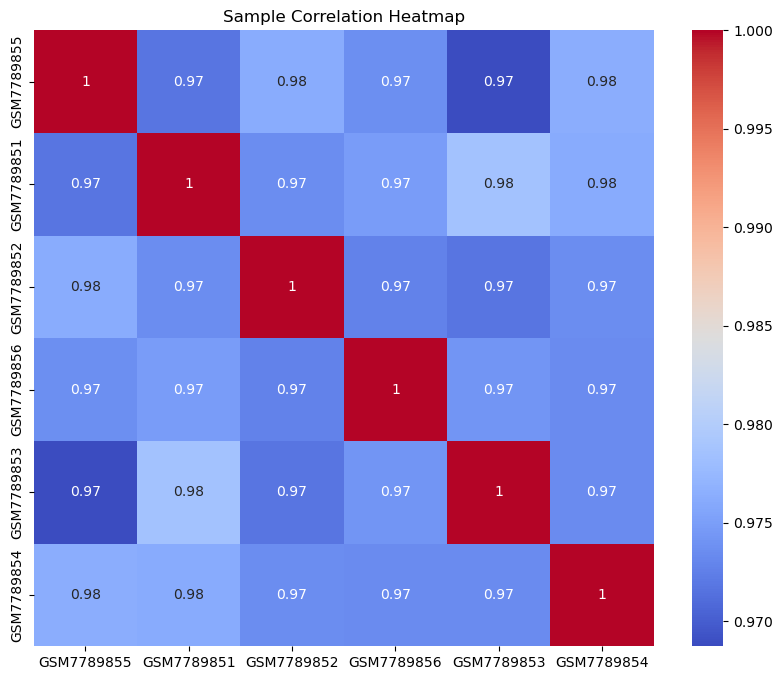

In [6]:
#EDA: boxplot, heatmap to check sample correlation

#Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_counts)
plt.xticks(rotation=45)
plt.title("Expression Distribution Across Samples")
plt.show()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_counts.corr(), annot=True, cmap="coolwarm")
plt.title("Sample Correlation Heatmap")
plt.show()


In [7]:
#Differential gene expression analysis 

control_cols = ["GSM7789851", "GSM7789852", "GSM7789853"]
pd_cols = ["GSM7789854", "GSM7789855", "GSM7789856"]

#Filtering for 0 counts 
valid_genes = (combined_counts[control_cols].mean(axis=1) > 0) & (combined_counts[pd_cols].mean(axis=1) > 0)
combined_counts = combined_counts.loc[valid_genes]
control_data = combined_counts[control_cols].values.T  
pd_data = combined_counts[pd_cols].values.T           

#T-test
results = pd.DataFrame(index=combined_counts.index)
results["log2_fold_change"] = np.log2(combined_counts[pd_cols].mean(axis=1) / combined_counts[control_cols].mean(axis=1))
t_stats, p_values = ttest_ind(control_data, pd_data, axis=0, nan_policy="omit")
results["p_value"] = p_values
results["fdr"] = multipletests(results["p_value"], method="fdr_bh")[1]

#Results 
significant_genes = results[results["fdr"] < 0.05].dropna()
print("Significant Genes:")
print(significant_genes.head())
print("Number of DEGs:", significant_genes.shape[0])
raw_significant = results[results["p_value"] < 0.05]
print("Genes with raw p-value < 0.05:")
print(raw_significant.head())
print("Number of raw significant genes:", raw_significant.shape[0])

Significant Genes:
Empty DataFrame
Columns: [log2_fold_change, p_value, fdr]
Index: []
Number of DEGs: 0
Genes with raw p-value < 0.05:
                       log2_fold_change   p_value  fdr
Geneid                                                
ENSMUSG00000000078.8           0.039366  0.015540  NaN
ENSMUSG00000000253.14          0.037678  0.025566  NaN
ENSMUSG00000000275.17          0.132663  0.008687  NaN
ENSMUSG00000000290.14          0.261160  0.019781  NaN
ENSMUSG00000000317.12          0.284172  0.005778  NaN
Number of raw significant genes: 1914


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [8]:
#look for tyrosine hydroxylase, an important PD gene
genes_of_interest = ["ENSMUSG00000000214"]
found_genes = [gene for gene in results.index if any(base in gene for base in genes_of_interest)]

print(f"Genes of interest: {found_genes}")
print(results.loc[found_genes])

Genes of interest: ['ENSMUSG00000000214.12']
                       log2_fold_change   p_value  fdr
Geneid                                                
ENSMUSG00000000214.12         -0.074711  0.317364  NaN


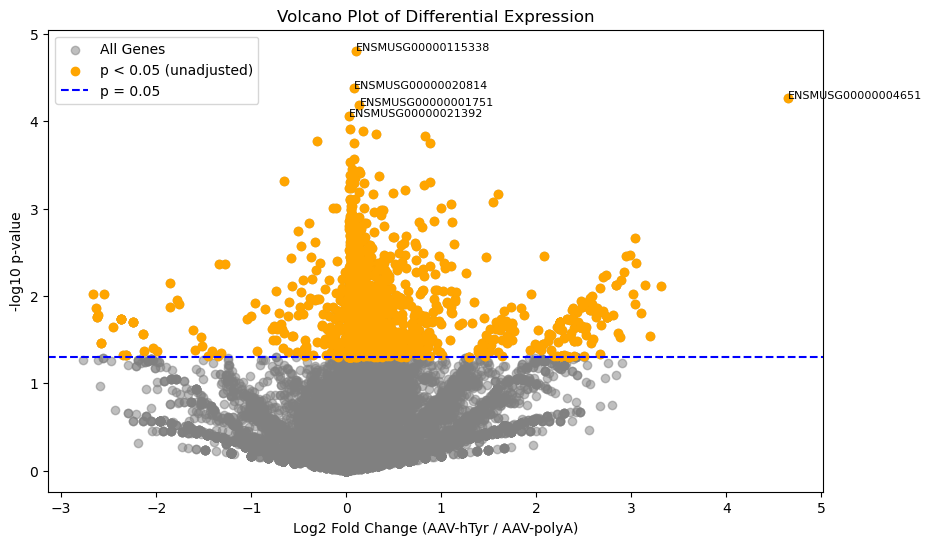

In [9]:
#volcano plot 
plt.figure(figsize=(10, 6))
plt.scatter(results["log2_fold_change"], -np.log10(results["p_value"]), c="grey", alpha=0.5, label="All Genes")
plt.scatter(raw_significant["log2_fold_change"], -np.log10(raw_significant["p_value"]), c="orange", label="p < 0.05 (unadjusted)")
plt.axhline(y=-np.log10(0.05), color="blue", linestyle="--", label="p = 0.05")
plt.xlabel("Log2 Fold Change (AAV-hTyr / AAV-polyA)")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot of Differential Expression")
top_genes = raw_significant.nsmallest(5, "p_value")
for gene in top_genes.index:
    plt.text(top_genes.loc[gene, "log2_fold_change"], 
             -np.log10(top_genes.loc[gene, "p_value"]), 
             gene.split(".")[0], fontsize=8)
plt.legend()
plt.savefig("volcano_plot.png", dpi=300, bbox_inches="tight")
plt.show()